In [1]:
import os
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo
import plotly.io as pio

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.robust.norms import HuberT
from skbio.stats.composition import ilr,clr,alr
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
import seaborn as sns
from scipy.stats import skew

from scipy.cluster.hierarchy import dendrogram, linkage

In [3]:
df = pd.DataFrame(pd.read_csv("./cost_of_living_us.csv"))
#loại bỏ ký tự null
df = df.dropna()
df.head()

,case_id,state,isMetro,areaname,county,family_member_count,housing_cost,food_cost,transportation_cost,healthcare_cost,other_necessities_cost,childcare_cost,taxes,total_cost,median_family_income
0,1,AL,True,"Montgomery, AL MSA",Autauga County,1p0c,8505.72876,3454.91712,10829.16876,5737.47984,4333.81344,0.0000,6392.94504,39254.0532,73010.414062
1,1,AL,True,"Montgomery, AL MSA",Autauga County,1p1c,12067.50240,5091.70788,11588.19288,8659.55640,6217.45896,6147.8298,7422.07836,57194.3256,73010.414062
2,1,AL,True,"Montgomery, AL MSA",Autauga County,1p2c,12067.50240,7460.20308,12361.77720,11581.63260,7075.65816,15824.6940,9769.56228,76141.0308,73010.414062
3,1,AL,True,"Montgomery, AL MSA",Autauga County,1p3c,15257.15040,9952.23924,13452.18600,14503.70760,9134.35620,18802.1892,13101.70320,94203.5328,73010.414062
4,1,AL,True,"Montgomery, AL MSA",Autauga County,1p4c,15257.15040,12182.21400,13744.59840,17425.78560,9942.36396,18802.1892,13469.21880,100823.5200,73010.414062


In [4]:

# Xác định các biến thành phần độc lập và biến giải thích
compositional_cols = ['food_cost','transportation_cost', 'healthcare_cost','other_necessities_cost','childcare_cost','taxes']

var_target = df['housing_cost']
# chuyển dữ liệu thành phần
compositional_data = df[compositional_cols]
compositional_data = compositional_data.div(compositional_data.sum(axis=1), axis=0)
compositional_data.head()


,food_cost,transportation_cost,healthcare_cost,other_necessities_cost,childcare_cost,taxes
0,0.112361,0.352187,0.186595,0.140945,0.000000,0.207912
1,0.112831,0.256792,0.191894,0.137777,0.136234,0.164472
2,0.116432,0.192931,0.180755,0.110430,0.246977,0.152474
3,0.126063,0.170396,0.183716,0.115703,0.238164,0.165957
4,0.142372,0.160631,0.203652,0.116195,0.219738,0.157413


In [6]:
# Thay thế các giá trị bằng 0 bằng một epsilon nhỏ
epsilon = 1e-9
compositional_data = compositional_data.replace(0, epsilon)

# Chuyển đổi dữ liệu thành phần bằng centered log-ratio (CLR)
clr_compositional_data = clr(compositional_data)

# Chuyển dữ liệu CLR về dạng DataFrame để tiện sử dụng
#clr_compositional_data = pd.DataFrame(clr_compositional_data, columns=compositional_cols)
clr_compositional_data = pd.DataFrame(clr_compositional_data)
clr_compositional_data.columns = compositional_cols
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(clr_compositional_data, var_target, test_size=0.2, random_state=42)


# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Thêm cột hằng số vào X_train và X_test cho mô hình hồi quy
X_train_scaled = sm.add_constant(X_train_scaled)
X_test_scaled = sm.add_constant(X_test_scaled)

# Tạo mô hình hồi quy mạnh mẽ (RLM) với chuẩn Huber
rlm_model = sm.RLM(y_train, X_train_scaled, M=HuberT())
rlm_results = rlm_model.fit()

# In kết quả mô hình
print(rlm_results.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:           housing_cost   No. Observations:                25136
Model:                            RLM   Df Residuals:                    25129
Method:                          IRLS   Df Model:                            6
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 27 Jun 2024                                         
Time:                        01:32:00                                         
No. Iterations:                    20                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.094e+04      6.896   1586.003      0.0

/tmp/ipykernel_68942/2516945283.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




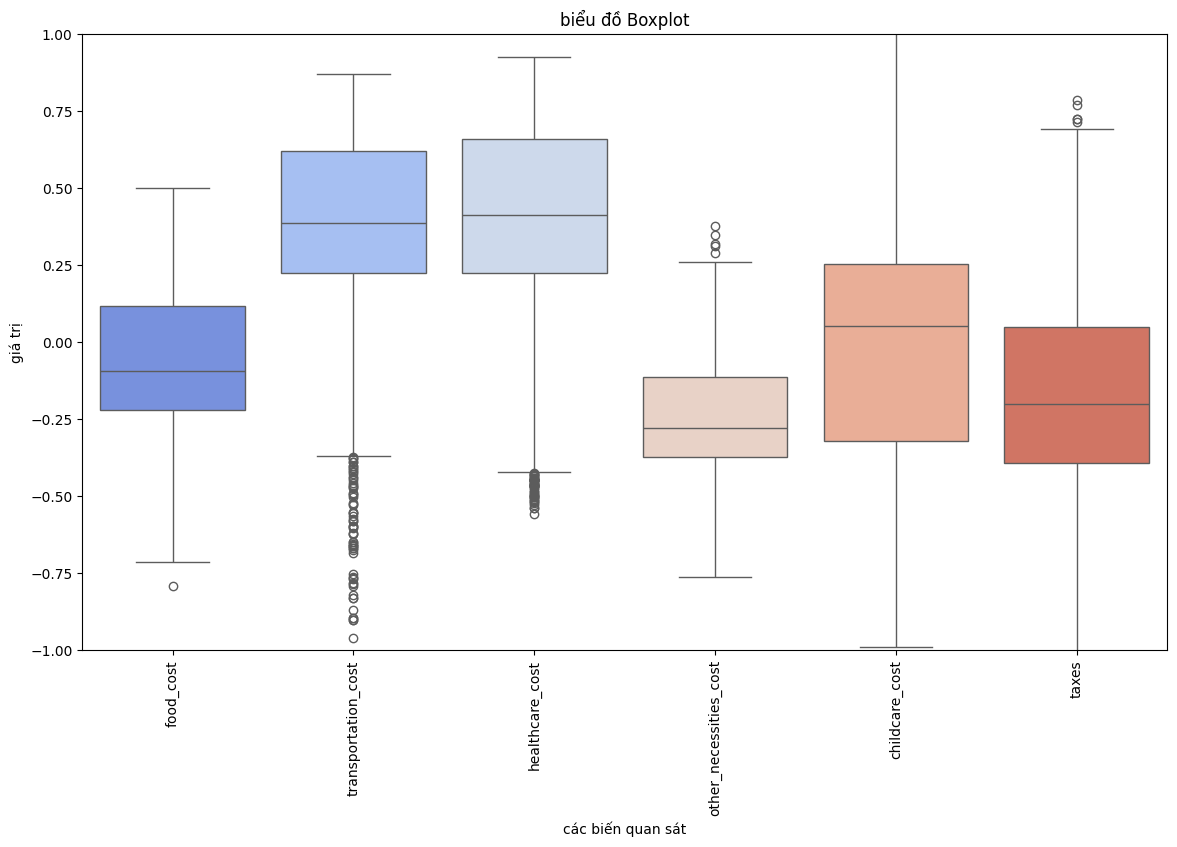

In [7]:
# Vẽ boxplot để xem phân phối của các biến
plt.figure(figsize=(14, 8))
X_scaled_melt = clr_compositional_data.melt(var_name='các biến quan sát', value_name='giá trị')
sns.boxplot(x='các biến quan sát', y='giá trị', data=X_scaled_melt, palette='coolwarm')
plt.title('biểu đồ Boxplot')
plt.xticks(rotation=90)
plt.ylim(-1, 1)  # Đặt giới hạn cho trục y từ -1 đến 1
plt.show()

In [8]:
# Dự đoán trên tập kiểm tra
y_pred = rlm_results.predict(X_test_scaled)

# Tính toán lỗi và RMSE
error = y_pred - y_test
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")


RMSE: 1750.7654133650356


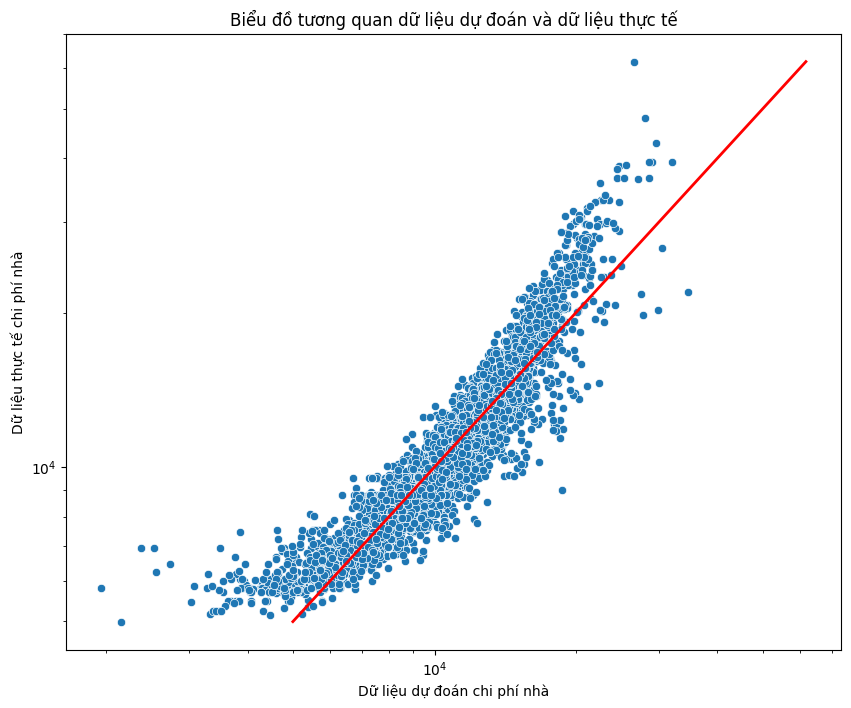

In [9]:
# Vẽ biểu đồ dự đoán so với giá trị thực tế
plt.figure(figsize=(10, 8))
sns.scatterplot(x=y_pred, y=y_test)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Dữ liệu dự đoán chi phí nhà')
plt.ylabel('Dữ liệu thực tế chi phí nhà')
plt.title('Biểu đồ tương quan dữ liệu dự đoán và dữ liệu thực tế')
plt.show()